In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])
seed_base(CFG["env"]["seed"])

2023-11-24 12:27:48.218317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 12:27:48.297816: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 12:27:48.797320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
onset = oof_xgb[oof_xgb["event"]=="onset"].rename(columns={"score":"onset_oof"}).drop(columns=["event"])
wakeup = oof_xgb[oof_xgb["event"]=="wakeup"].rename(columns={"score":"wakeup_oof"}).drop(columns=["event"])
oof_xgb = pd.merge(onset, wakeup, on=["series_id", "step"], how="inner").reset_index(drop=True)
oof_xgb.head()

,series_id,step,onset_oof,wakeup_oof
0,038441c925bb,461,-0.001241,-0.011036
1,038441c925bb,473,-0.000141,-0.008148
2,038441c925bb,485,-0.002866,-0.019270
3,038441c925bb,497,-0.003675,-0.034190
4,038441c925bb,509,-0.008578,-0.007777


In [3]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004654,0.000332
1,05e1944c3818,18,0.003008,0.000308
2,05e1944c3818,30,0.002308,0.000296
3,05e1944c3818,42,0.001987,0.000282
4,05e1944c3818,54,0.001864,0.000265


In [4]:
oof_tubo_based = pd.read_parquet(f'/kaggle/output/tubo_based/exp019_oof.parquet')
oof_tubo_based[['onset_oof', 'wakeup_oof']] /= 1.5
oof_tubo_based.head()

,series_id,step,onset_oof,wakeup_oof
0,05e1944c3818,0,0.022507,0.008564
1,05e1944c3818,1,0.017853,0.006650
2,05e1944c3818,2,0.008532,0.002813
3,05e1944c3818,3,0.003805,0.001105
4,05e1944c3818,4,0.003659,0.001520


In [5]:
oof_nikhil = pd.read_parquet(f'/kaggle/output/nikhil_output/oof_preds.parquet').rename(columns={"onset":"onset_oof", "wakeup":"wakeup_oof"})
oof_nikhil[["wakeup_oof", "onset_oof"]] *= 0.5
oof_nikhil.head()

,series_id,step,onset_oof,wakeup_oof
0,038441c925bb,0,0.149984,0.030692
1,038441c925bb,1,0.146346,0.050954
2,038441c925bb,2,0.195569,0.054549
3,038441c925bb,3,0.209685,0.037639
4,038441c925bb,4,0.205542,0.021645


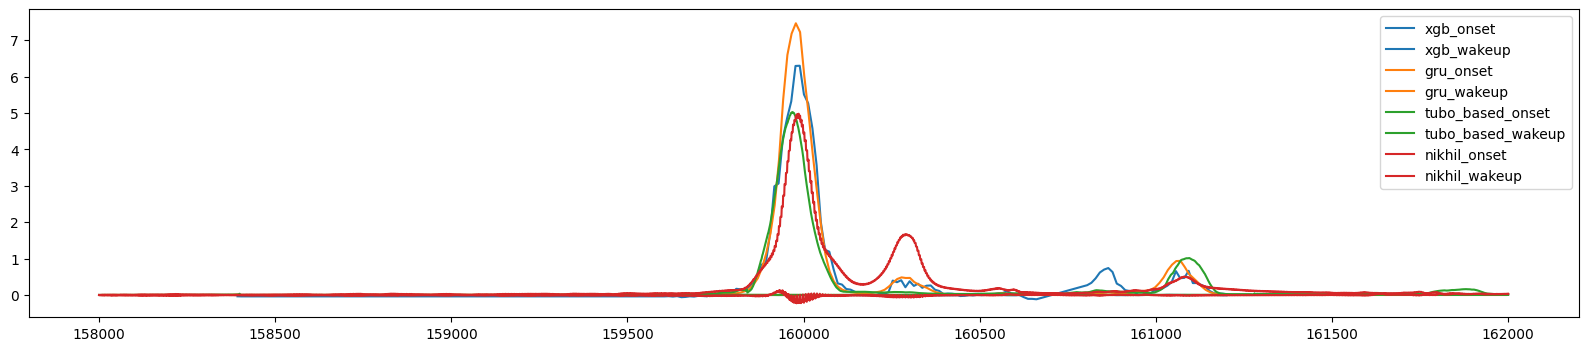

In [6]:
series_id = oof_xgb["series_id"].unique()[0]
min_step = 158000
max_step = 162000

cmap = plt.get_cmap("tab10") 
dfs = [oof_xgb, oof_gru, oof_tubo_based, oof_nikhil]
names = ["xgb", "gru", "tubo_based", "nikhil"]
plt.subplots(figsize=(20, 4))
for i, (df, name) in enumerate(zip(dfs, names)):
    df = df[df["series_id"]==series_id]
    df = df[(df["step"]>=min_step) & (df["step"]<=max_step)]
    plt.plot(df["step"], df["onset_oof"], label=f"{name}_onset", c=cmap(i))
    plt.plot(df["step"], df["wakeup_oof"], label=f"{name}_wakeup", c=cmap(i))
plt.legend()
plt.show()

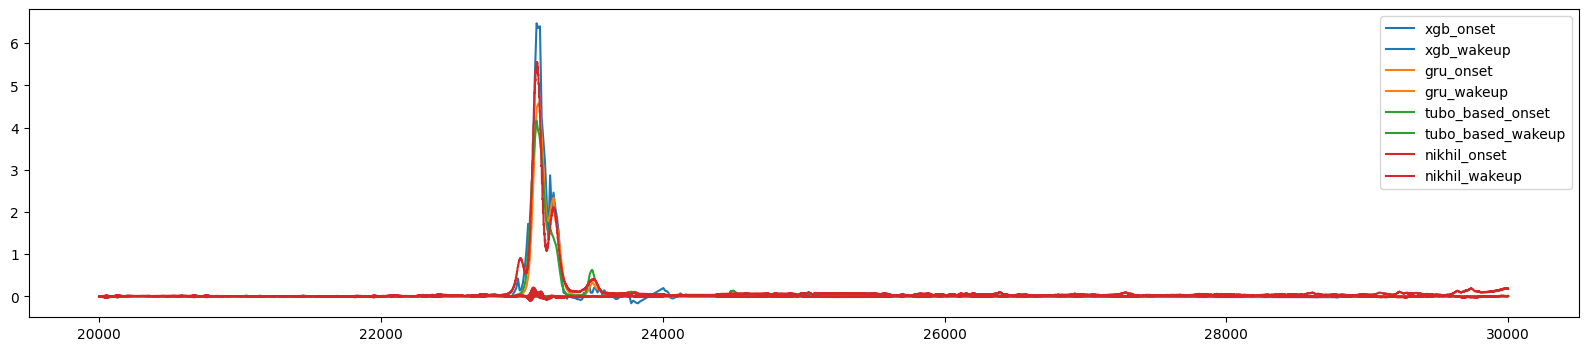

In [7]:
series_id = oof_xgb["series_id"].unique()[1]
min_step = 20000
max_step = 30000

cmap = plt.get_cmap("tab10") 
dfs = [oof_xgb, oof_gru, oof_tubo_based, oof_nikhil]
names = ["xgb", "gru", "tubo_based", "nikhil"]
plt.subplots(figsize=(20, 4))
for i, (df, name) in enumerate(zip(dfs, names)):
    df = df[df["series_id"]==series_id]
    df = df[(df["step"]>=min_step) & (df["step"]<=max_step)]
    plt.plot(df["step"], df["onset_oof"], label=f"{name}_onset", c=cmap(i))
    plt.plot(df["step"], df["wakeup_oof"], label=f"{name}_wakeup", c=cmap(i))
plt.legend()
plt.show()

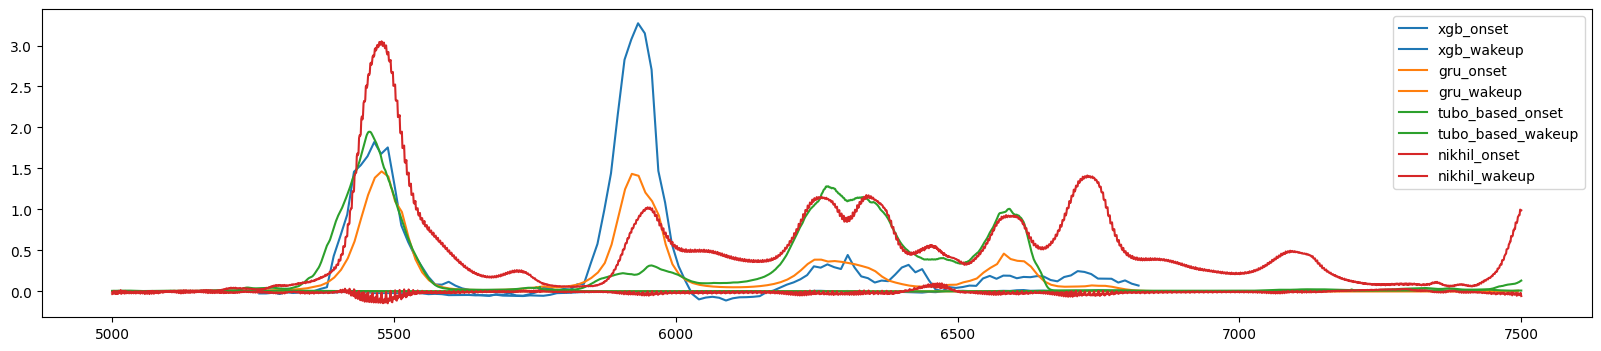

In [8]:
series_id = oof_xgb["series_id"].unique()[2]
min_step = 5000
max_step = 7500

cmap = plt.get_cmap("tab10") 
dfs = [oof_xgb, oof_gru, oof_tubo_based, oof_nikhil]
names = ["xgb", "gru", "tubo_based", "nikhil"]
plt.subplots(figsize=(20, 4))
for i, (df, name) in enumerate(zip(dfs, names)):
    df = df[df["series_id"]==series_id]
    df = df[(df["step"]>=min_step) & (df["step"]<=max_step)]
    plt.plot(df["step"], df["onset_oof"], label=f"{name}_onset", c=cmap(i))
    plt.plot(df["step"], df["wakeup_oof"], label=f"{name}_wakeup", c=cmap(i))
plt.legend()
plt.show()

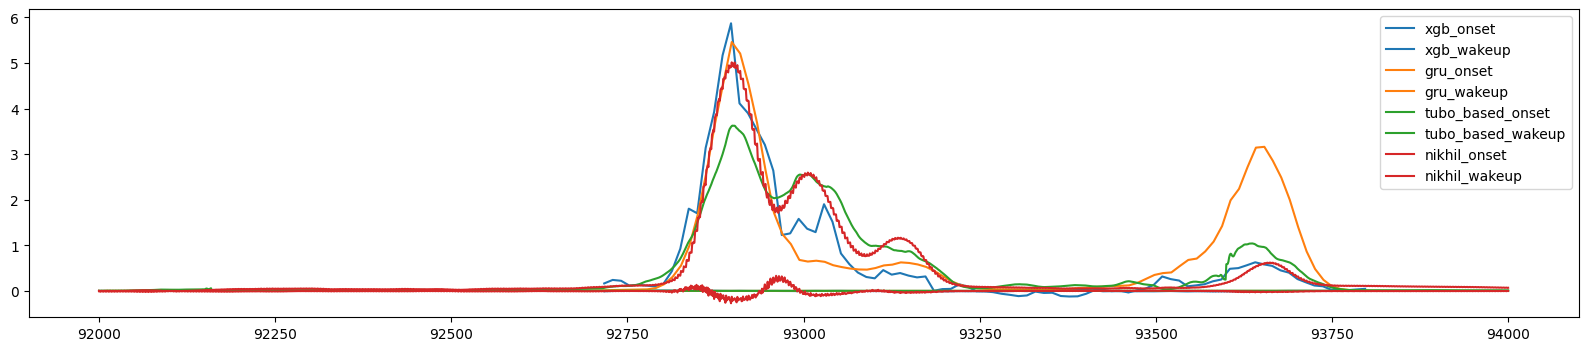

In [9]:
series_id = oof_xgb["series_id"].unique()[3]
min_step = 92000
max_step = 94000

cmap = plt.get_cmap("tab10") 
dfs = [oof_xgb, oof_gru, oof_tubo_based, oof_nikhil]
names = ["xgb", "gru", "tubo_based", "nikhil"]
plt.subplots(figsize=(20, 4))
for i, (df, name) in enumerate(zip(dfs, names)):
    df = df[df["series_id"]==series_id]
    df = df[(df["step"]>=min_step) & (df["step"]<=max_step)]
    plt.plot(df["step"], df["onset_oof"], label=f"{name}_onset", c=cmap(i))
    plt.plot(df["step"], df["wakeup_oof"], label=f"{name}_wakeup", c=cmap(i))
plt.legend()
plt.show()